In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore') # filter some warning messages
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature
import seaborn as sns
import glob
import os
import fnmatch
import calendar

In [2]:
# Generals
ldp = '/Users/sol/Documents/LargeData/' # data folder

# regional domain
lnep = np.array([[43, 48.5],[-129, -123]]) # 230, 237
lqin = np.array([[46.25, 47.75],[-125.5, -123.5]]) # 230, 237 # domain for zoom in map
# QIN region
qbox = np.array([[-124.05,-124.33,-125.07,-124.774,-124.05],[46.53,47.4,47.4,46.53,46.53]]) 
# calendar.month_name[mon]
pers=['Dec-Feb','Jun-Aug']

In [3]:
fn = '../data/ETOPO1_QIN.nc'
ds_topo = xr.open_dataset(fn)
ds_topo.close()
topo = ds_topo.z.sel(y=slice(lnep[0,0],lnep[0,1]),x=slice(lnep[1,0],lnep[1,1]))
X,Y=np.meshgrid(topo.x,topo.y)

In [4]:
qin = xr.open_dataset(ldp+'/QIN/qin_mask.nc')
qin.close()
qin.coords['lon'] = np.mod(qin.coords['lon'] + 180,360) - 180
qin = qin.polygon_mask.sel(lat=slice(lnep[0,0],lnep[0,1]),lon=slice(lnep[1,0],lnep[1,1]))
qin = qin.where(qin!=0,np.nan)

# number of pixels in the mask
npx = qin.count(dim=['lat','lon']).values

In [5]:
fishdt = pd.read_csv('../data/QiN_dataspecifics.csv')
# https://docs.google.com/spreadsheets/d/1zYiVVgZR4DLksM_yABO_zPnsXe7Q6Uh_8tvxt3n60N0/edit?usp=sharing')
# Transform O2
fishdt['Om'] = fishdt['Om']/44.661
var = ['thetao','o2']   
depth = ['surface','bottom']
ssps = ['ssp245', 'ssp585']
fishes=fishdt['Species']

In [6]:
fishes

0    Dungeness Crab
1         Sablefish
2        P. Halibut
3           Chinook
4              Coho
5       Razor Clams
6          Albacore
7    Black Rockfish
Name: Species, dtype: object

In [7]:
def get_suitable_habitat_values(x, m, s, z):
    func = lambda x, m, s, z: z * np.exp(-0.5*((x - m)/s)**2)
    return xr.apply_ufunc(func, x, m, s, z)

def T_weighted_suitable_habitat(fishnum, ds_tmp):
    import math
    
    # generate mask for final tally
    mask1 = ds_tmp.where((ds_tmp>=fishdt['Tm'][fishnum])&(ds_tmp<=fishdt['Tx'][fishnum]), np.nan)*0 + 1
    mask2 = ds_tmp.where((ds_tmp<=fishdt['Tm'][fishnum])|(ds_tmp>=fishdt['Tx'][fishnum]), np.nan)*0
    mask = xr.concat((mask1,mask2),'z').mean(dim='z')
    #mask = ds_tmp.where((ds_tmp>=Trange[fishnum,0])&(ds_tmp<=Trange[fishnum,1]), np.nan)
    
    # define normal distribution for the t range and set values
    m = (fishdt['Tx'][fishnum]+fishdt['Tm'][fishnum])/2
    s = (fishdt['Tx'][fishnum]-fishdt['Tm'][fishnum])*0.68/2
    # scale to 0-1
    xw = np.arange(fishdt['Tm'][fishnum], fishdt['Tx'][fishnum], 0.01)
    z = 1/s/np.sqrt(2*math.pi)
    yw = z * np.exp(-0.5*((xw - m)/s)**2)
    ymin = yw.min()
    ymax = (yw-ymin).max()
    #ymax = yw.max()
    #plt.plot(xw, (yw-ymin)/ymax)
    #plt.show()
    
    ds_new = get_suitable_habitat_values(ds_tmp, m, s, z)
    ds_new = (ds_new - ymin)*100 / ymax
    #ds_new = (ds_new)*100 / ymax
    ds_new = ds_new * mask
    
    return ds_new
    

In [8]:
def suitable_habitat_seas_allmod_comb(fishnum):            
    
    for clim in ssps:
        for i2 in depth:
            # for each variable at given depth
            for i in var:
                # optimal range thresholds
                if i=='thetao':
                    th1 = fishdt['Tm'][fishnum]
                    th2 = fishdt['Tx'][fishnum]
                else:
                    if fishdt['Om'][fishnum]<=1.4:
                        th1 = 1.4
                    else:
                        th1 = fishdt['Om'][fishnum]
                # for each model
                fns = glob.glob(ldp+'/QIN/downscaled_data/'+clim+'/'+i+'/'+i2+'/*.nc')
                # build datasets from all models
                for modn,fn in enumerate(fns):
                    # model name
                    tmps = fn.split('/')
                    tmps2 = tmps[-1].split('_')
                    modname = tmps2[0]+'_'+tmps2[1]
                    #print(modn,models[nummod])
                    ds_Ts = xr.open_dataset(fn)
                    ds_Ts.close()
                    ds_Ts.coords['lon'] = np.mod(ds_Ts.coords['lon'] + 180,360) - 180
                    # select only region of interest (large)
                    ds_Ts = ds_Ts[i].sel(lat=slice(lnep[0,0],lnep[0,1]),lon=slice(lnep[1,0],lnep[1,1]),time=slice('2060-01-01','2079-12-31')).groupby('time.season').mean()
                    
                    if i=='thetao':
                        # calculate suitable habitat for T
                        tmp = T_weighted_suitable_habitat(fishnum, ds_Ts)
                    else:
                        #tmp = ds_Ts.where((ds_Ts>=th1)&(ds_Ts<=th2), np.nan)
                        tmp = ds_Ts.where(ds_Ts<th1, 1)
                        tmp = tmp.where(tmp==1, 0)
                        #tmp = tmp*qin
                    
                    # data array
                    if modn==0:
                        fechas = ds_Ts.season
                    tmp_ds = xr.DataArray(data=tmp,dims=['season','lat','lon'],
                                        coords=dict(season=fechas,lat=ds_Ts.lat,lon=ds_Ts.lon))
                    
                    if i=='thetao':
                        if modn==0: 
                            allmodT = xr.Dataset({modname:tmp_ds})
                        else:
                            allmodT[modname] = tmp_ds
                    else:
                        if modn==0: 
                            allmodO = xr.Dataset({modname:tmp_ds})
                        else:
                            allmodO[modname] = tmp_ds
                    
            # compare that both vars in each models
            # for each model that has Oxygen
            di = 0
            for i in list(allmodO):
                tmpO = allmodO[i].values
                try:
                    tmpT = allmodT[i].values
                    OTcomb = tmpO * tmpT
                    tmp_OT = xr.DataArray(data=OTcomb, dims=['season','lat','lon'],
                                        coords=dict(season=fechas,lat=ds_Ts.lat,lon=ds_Ts.lon))
                    
                    if di==0:
                        allmod_otcomb = xr.Dataset({i:tmp_OT})
                        di += 1
                    else:
                        allmod_otcomb[i] = tmp_OT
                except:
                    x=1
                    
            varns = clim+'_'+i2
            allmod_otcomb.to_netcdf(ldp+'QIN/downscaled_data/suitable_habitat_v2/future_season_OT_'+fishes[fishnum]+'_'+varns+'_allmods.nc')
            

In [9]:
#for fishn in range(len(fishes)):
    #suitable_habitat_seas_allmod_comb(fishn)
suitable_habitat_seas_allmod_comb(4)

In [15]:
def make_map(ds, dom, tit, dp, ssp, depth=False, d1=0, cbs=True):
    comap='RdYlGn'
    cd = 'b'
        
    pers=['Dec-Feb','Jun-Aug']
    
    for i in range(2):
        print(pers[i])
        if cbs==True: # QIN Domain
            fig=plt.figure(figsize=(2.5,3),dpi=150) # QIN domain
        else:
            fig=plt.figure(figsize=(2,2),dpi=150)
        fig.patch.set_facecolor('white')
        fig.patch.set_alpha(0)
        ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
        ax.coastlines(resolution='10m',linewidth=1.5,color='black',alpha=0.8,zorder=4)
        ax.add_feature(cfeature.LAND, color='lightgrey')
        ax.set_extent([dom[1,0],dom[1,1],dom[0,0],dom[0,1]],crs=ccrs.PlateCarree())
        if dom[1,1]-dom[1,0]>3:
            xt = range(int(np.ceil(dom[1,0])), int(np.floor(dom[1,1]))+1,3)
        else:
            xt = range(int(np.ceil(dom[1,0])), int(np.floor(dom[1,1]))+1,1)
        if dom[0,1]-dom[0,0]>3:
            yt = range(int(np.ceil(dom[0,0])), int(np.floor(dom[0,1]))+1,2)
        else:
            yt = range(int(np.ceil(dom[0,0])), int(np.floor(dom[0,1]))+1,1)
        
        ax.set_xticks(xt, crs=ccrs.PlateCarree())
        ax.set_yticks(yt, crs=ccrs.PlateCarree())
        plt.xticks(fontsize=8)
        plt.yticks(fontsize=8)
        ax.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True))
        ax.yaxis.set_major_formatter(LatitudeFormatter())
        plt.grid(True, zorder=0,alpha=0.5)
        ax.set_aspect(1.5)
        plt.contour(X,Y,topo,[-3000,-2000,-1000,-500,-200,-150, -100,-50],colors='k',linewidths=0.5, linestyles='solid', zorder=3, alpha=0.5)
        
        if depth==True:
            plt.contour(X,Y,topo,[-d1],colors=cd,linewidths=1, linestyles='solid', zorder=3, alpha=0.8)
        
        plt.plot(qbox[0,:],qbox[1,:],c='k',lw=2,zorder=5, alpha=0.7)
        plt.text(dom[1,0]+0.1,dom[0,1]-0.1, pers[i],fontsize=8,backgroundcolor='w')
        
        vmi = 0
        vmx = 100
        
        print(ds[i,:,:].count().values)
        if ds[i,:,:].count()>18:
            #print(pers[i])
            plt.contourf(ds.lon, ds.lat, ds[i,:,:], cmap=comap, alpha=0.9, vmin=vmi, vmax=vmx)
            print('aqui')
            if cbs==True:
                cb = plt.colorbar(fraction=0.03, orientation='horizontal', ticks=[*range(vmi,vmx+1,20)])
                cb.ax.tick_params(labelsize='x-small')
                cb.set_label(label=tit, size='x-small')#, weight='bold')
        else:
            print('no hay datos: '+str(ds[i,:,:].count().values))
            #if cbs==True:
            #    cb = plt.colorbar(fraction=0.03, orientation='horizontal', ticks=[*range(vmi,vmx+1,20)])
            #    print('here')
                
        plt.tight_layout(h_pad=1)
        if cbs==True:
            plt.savefig('../figures/suitable_habitat/future/'+fishes[fishn]+'_'+dp+'_'+ssp+'_seas'+str(i+1)+'_QINdomain.png')
        else:
            plt.savefig('../figures/suitable_habitat/future/'+fishes[fishn]+'_'+dp+'_'+ssp+'_seas'+str(i+1)+'_Largedomain.png')
        
        plt.show()
        

Dungeness Crab
surface
Dec-Feb
2282
aqui


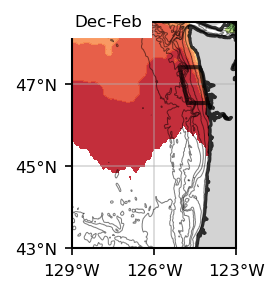

Jun-Aug
0
no hay datos: 0


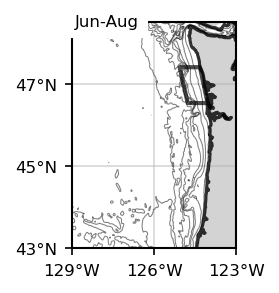

Dec-Feb
308
aqui


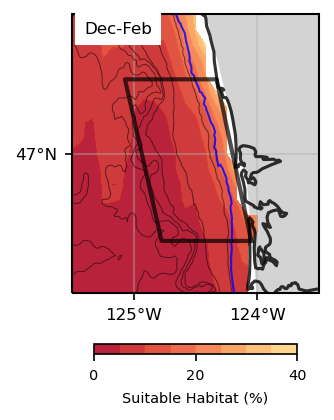

Jun-Aug
0
no hay datos: 0


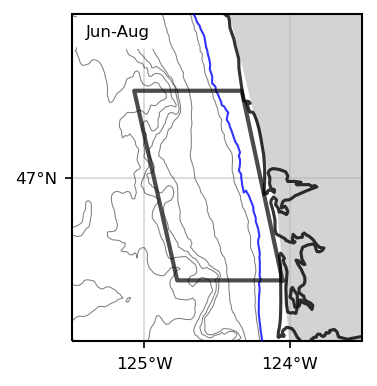

Dungeness Crab
bottom
Dec-Feb
231
aqui


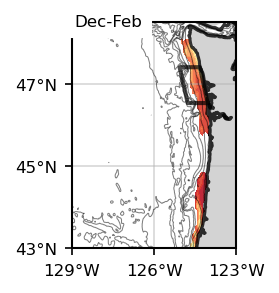

Jun-Aug
51
aqui


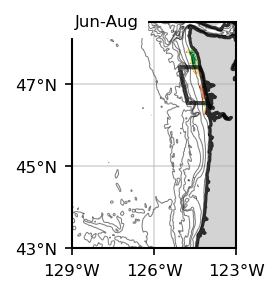

Dec-Feb
102
aqui


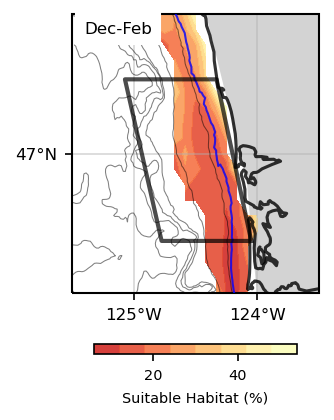

Jun-Aug
46
aqui


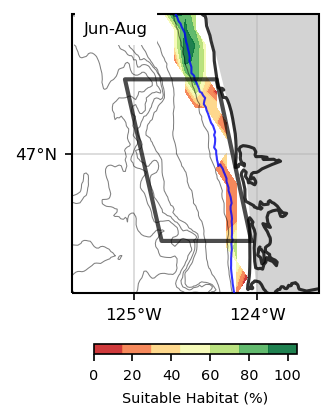

Sablefish
surface
Dec-Feb
3914
aqui


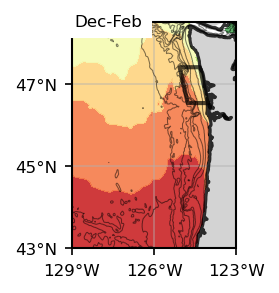

Jun-Aug
7
no hay datos: 7


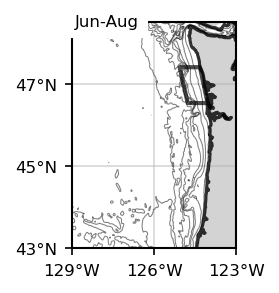

Dec-Feb
308
aqui


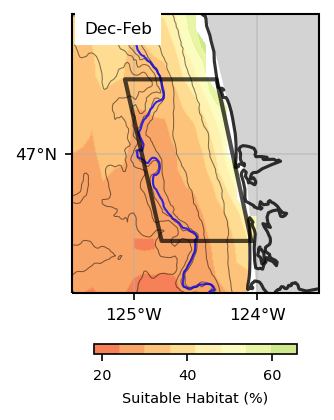

Jun-Aug
0
no hay datos: 0


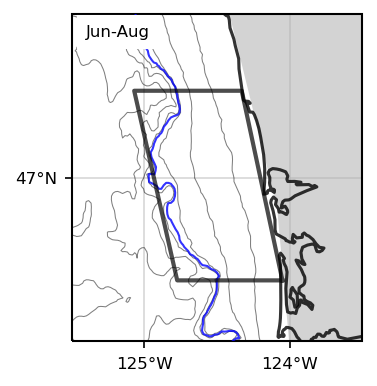

Sablefish
bottom
Dec-Feb
468
aqui


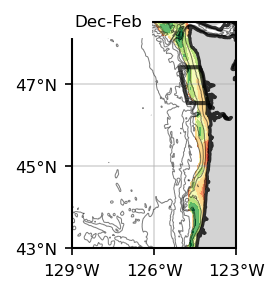

Jun-Aug
264
aqui


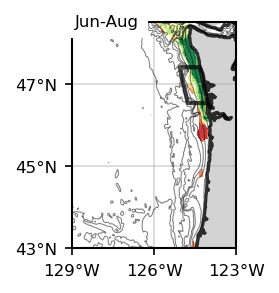

Dec-Feb
133
aqui


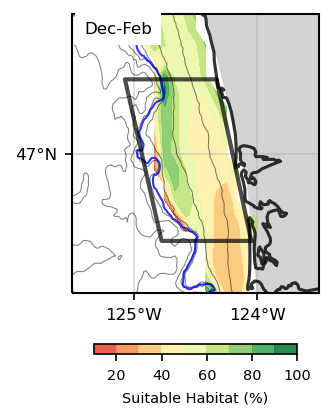

Jun-Aug
112
aqui


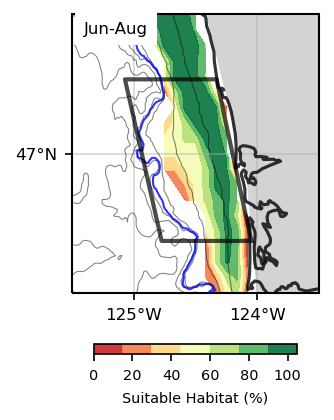

P. Halibut
surface
Dec-Feb
1
no hay datos: 1


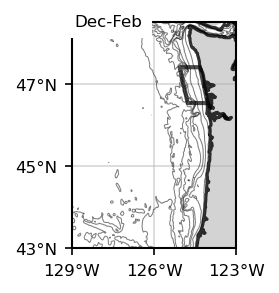

Jun-Aug
0
no hay datos: 0


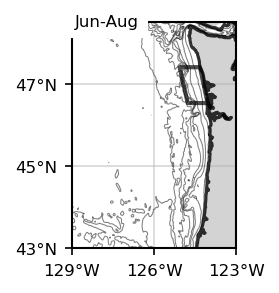

Dec-Feb
0
no hay datos: 0


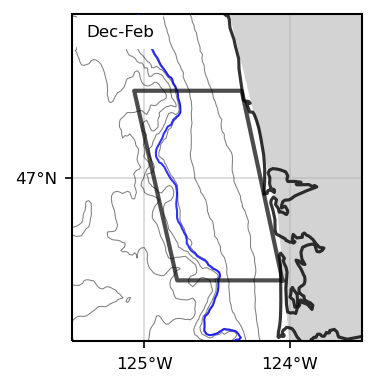

Jun-Aug
0
no hay datos: 0


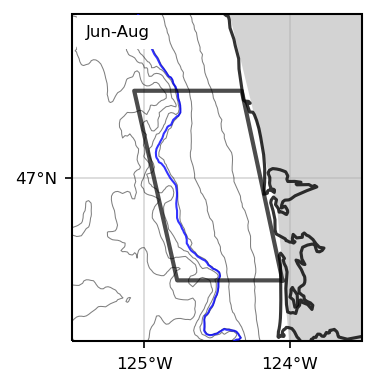

P. Halibut
bottom
Dec-Feb
149
aqui


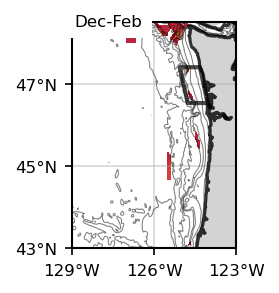

Jun-Aug
273
aqui


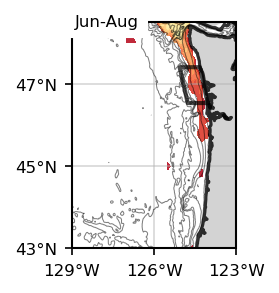

Dec-Feb
15
no hay datos: 15


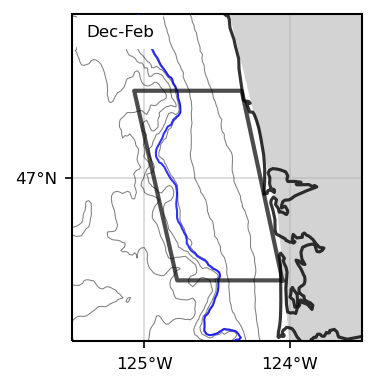

Jun-Aug
91
aqui


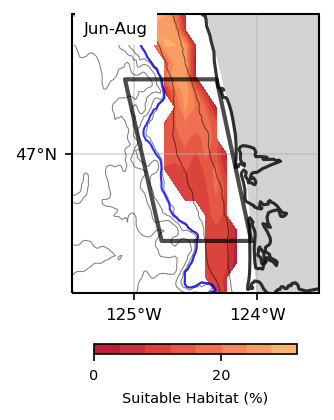

Chinook
surface
Dec-Feb
2016
aqui


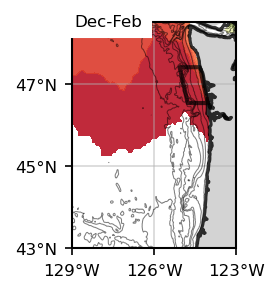

Jun-Aug
0
no hay datos: 0


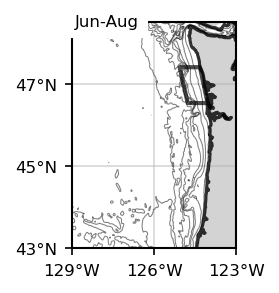

Dec-Feb
306
aqui


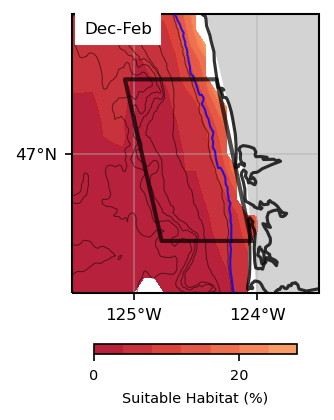

Jun-Aug
0
no hay datos: 0


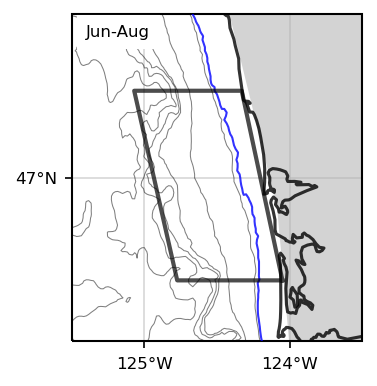

Chinook
bottom
Dec-Feb
482
aqui


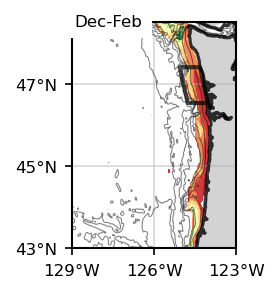

Jun-Aug
263
aqui


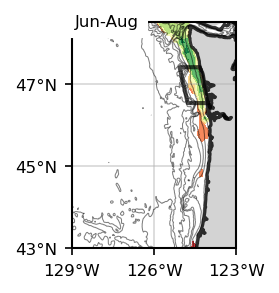

Dec-Feb
133
aqui


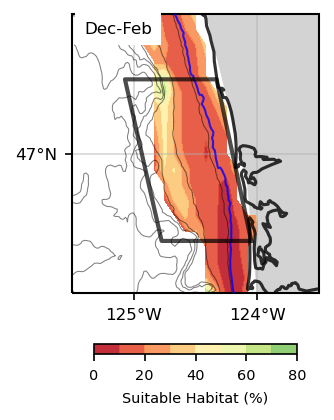

Jun-Aug
105
aqui


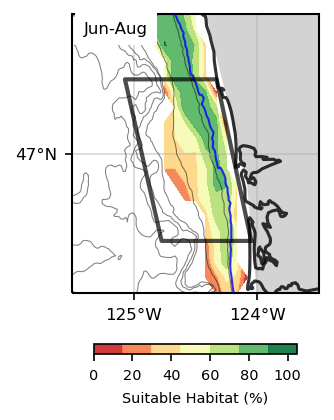

Coho
surface
Dec-Feb
3651
aqui


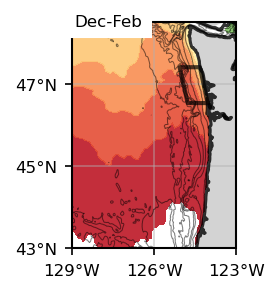

Jun-Aug
1
no hay datos: 1


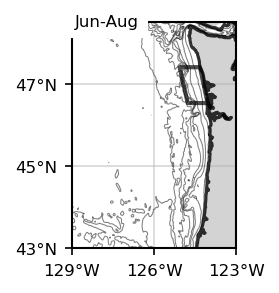

Dec-Feb
308
aqui


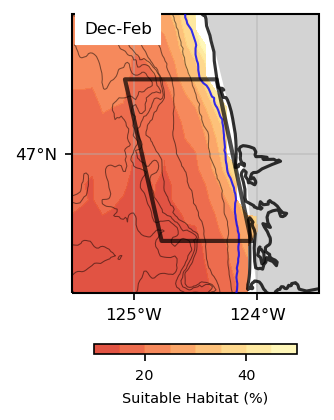

Jun-Aug
0
no hay datos: 0


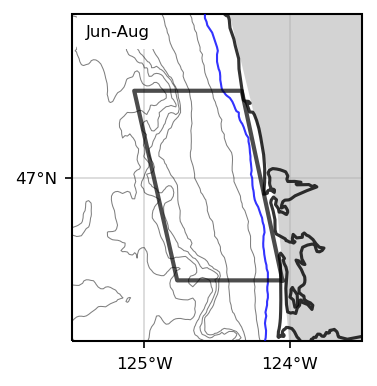

Coho
bottom
Dec-Feb
468
aqui


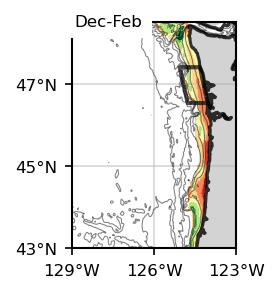

Jun-Aug
262
aqui


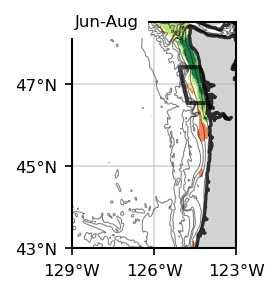

Dec-Feb
133
aqui


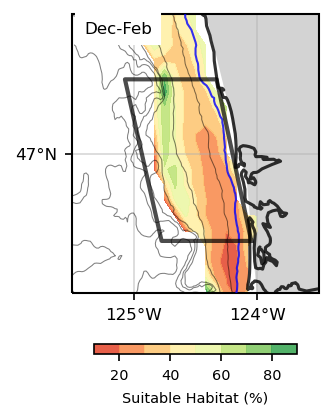

Jun-Aug
110
aqui


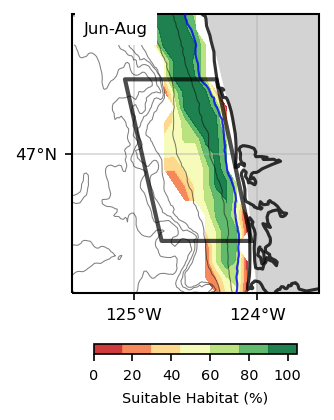

Razor Clams
surface
Dec-Feb
3914
aqui


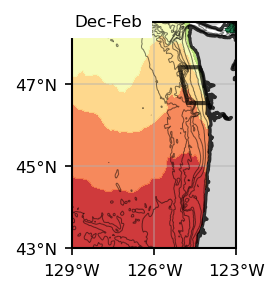

Jun-Aug
6
no hay datos: 6


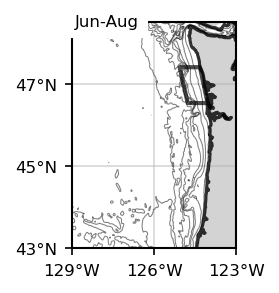

Dec-Feb
308
aqui


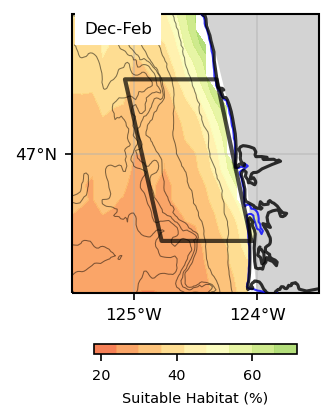

Jun-Aug
0
no hay datos: 0


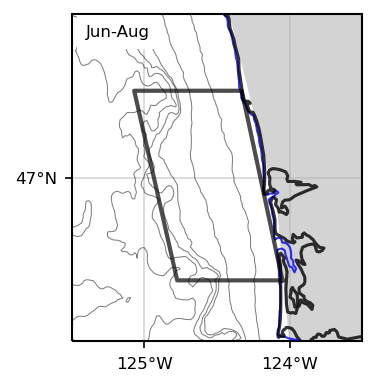

Razor Clams
bottom
Dec-Feb
231
aqui


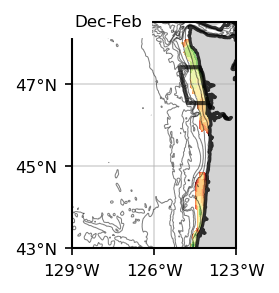

Jun-Aug
50
aqui


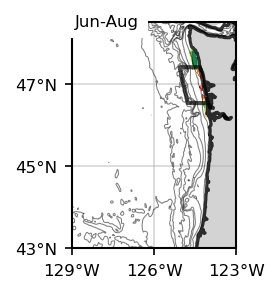

Dec-Feb
102
aqui


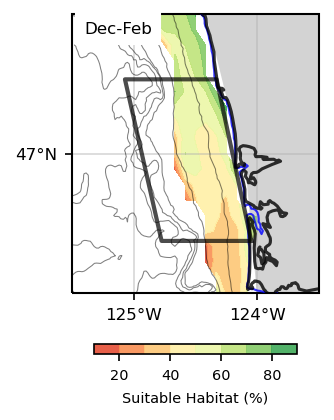

Jun-Aug
46
aqui


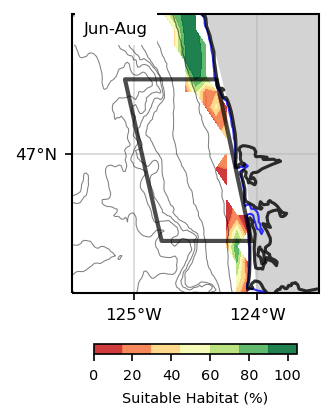

Albacore
surface
Dec-Feb
3149
aqui


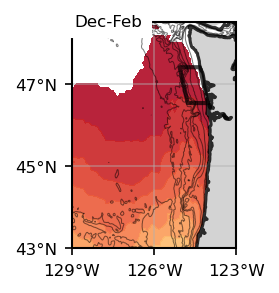

Jun-Aug
3914
aqui


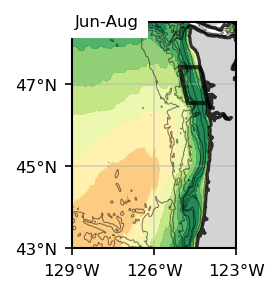

Dec-Feb
280
aqui


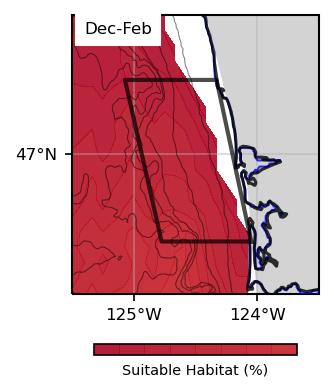

Jun-Aug
308
aqui


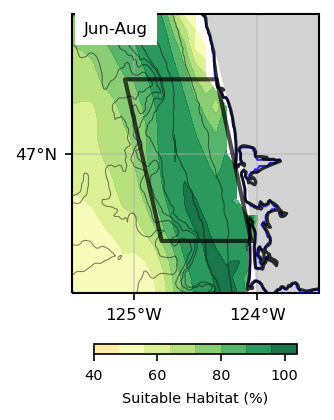

Albacore
bottom
Dec-Feb
49
aqui


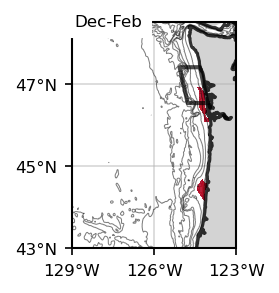

Jun-Aug
7
no hay datos: 7


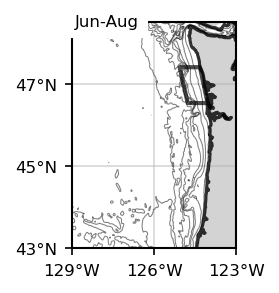

Dec-Feb
23
aqui


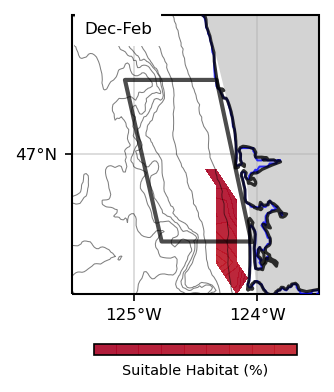

Jun-Aug
7
no hay datos: 7


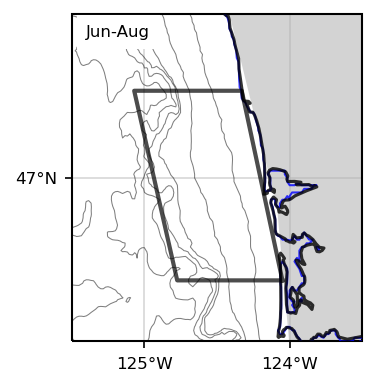

Dungeness Crab
surface
Dec-Feb
1058
aqui


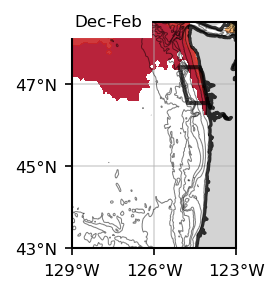

Jun-Aug
0
no hay datos: 0


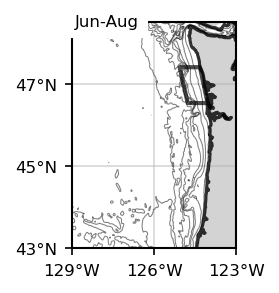

Dec-Feb
121
aqui


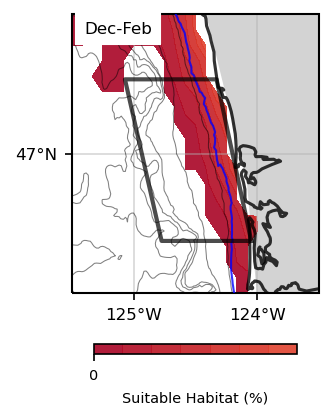

Jun-Aug
0
no hay datos: 0


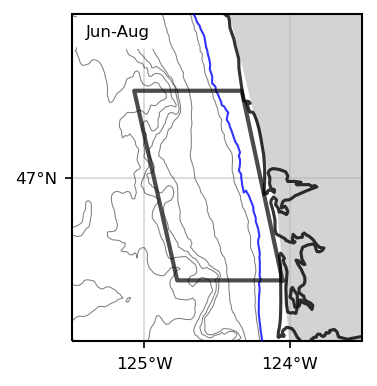

Dungeness Crab
bottom
Dec-Feb
197
aqui


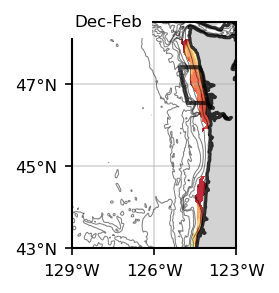

Jun-Aug
35
aqui


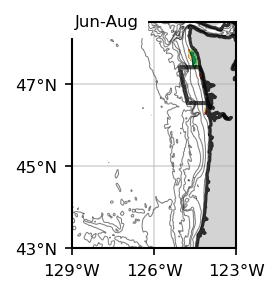

Dec-Feb
96
aqui


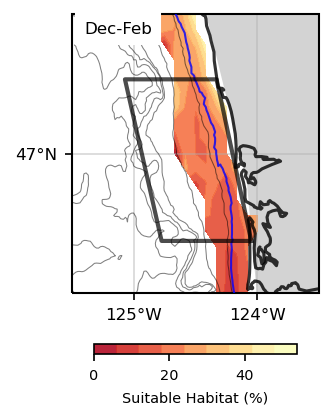

Jun-Aug
30
aqui


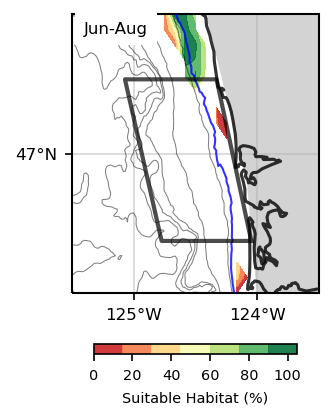

Sablefish
surface
Dec-Feb
3726
aqui


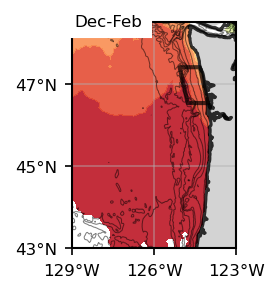

Jun-Aug
1
no hay datos: 1


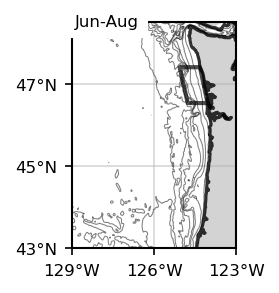

Dec-Feb
308
aqui


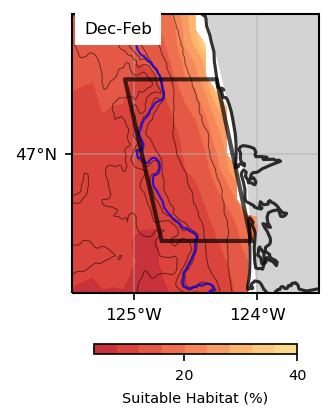

Jun-Aug
0
no hay datos: 0


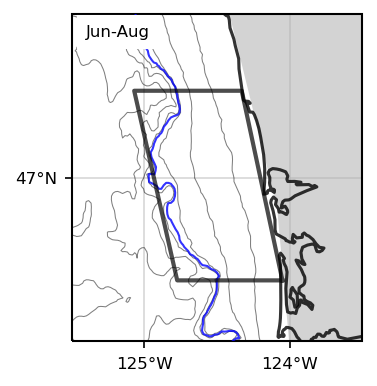

Sablefish
bottom
Dec-Feb
454
aqui


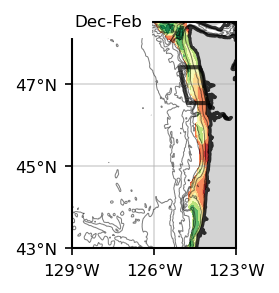

Jun-Aug
202
aqui


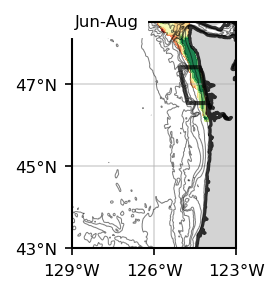

Dec-Feb
128
aqui


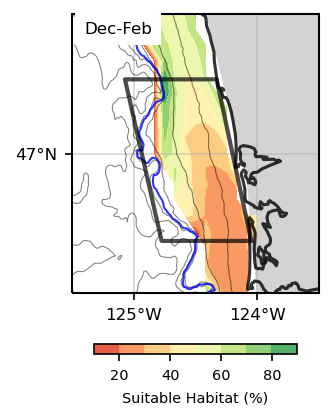

Jun-Aug
95
aqui


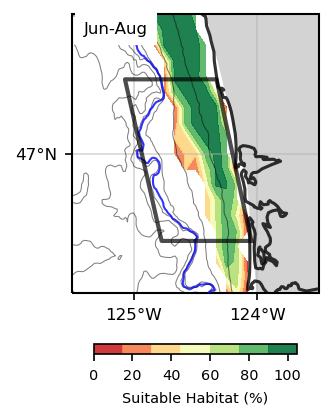

P. Halibut
surface
Dec-Feb
0
no hay datos: 0


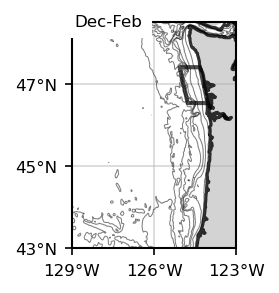

Jun-Aug
0
no hay datos: 0


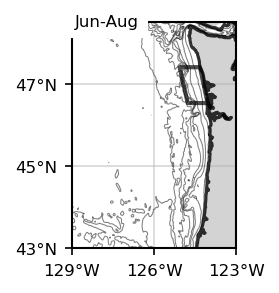

Dec-Feb
0
no hay datos: 0


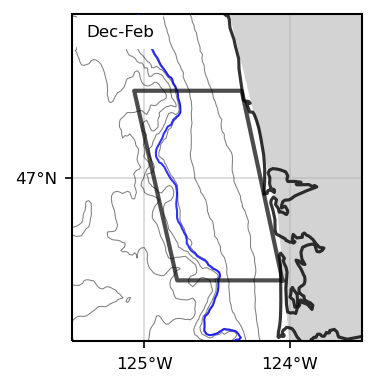

Jun-Aug
0
no hay datos: 0


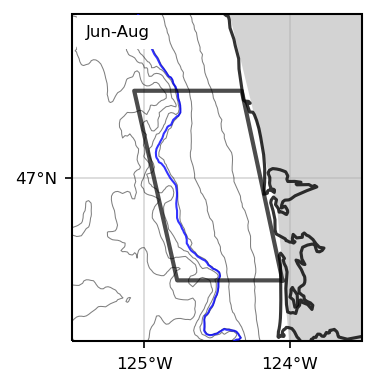

P. Halibut
bottom
Dec-Feb
176
aqui


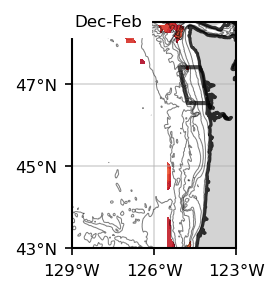

Jun-Aug
278
aqui


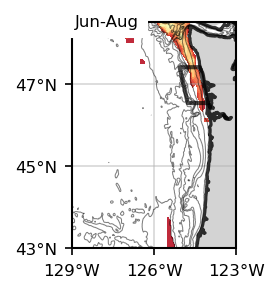

Dec-Feb
5
no hay datos: 5


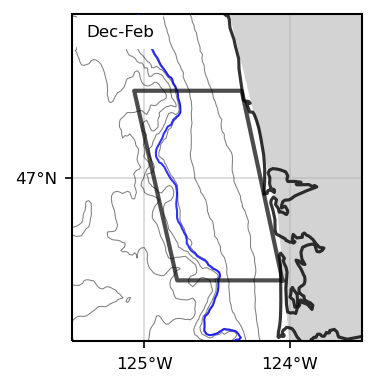

Jun-Aug
74
aqui


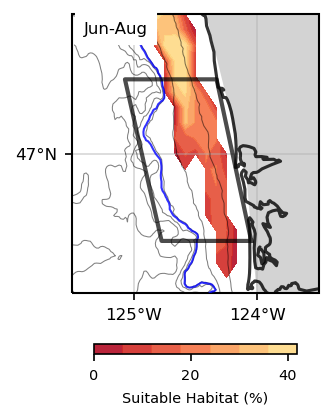

Chinook
surface
Dec-Feb
761
aqui


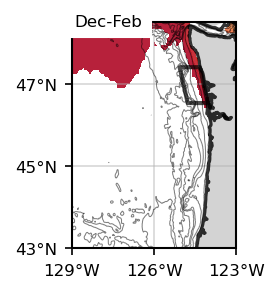

Jun-Aug
0
no hay datos: 0


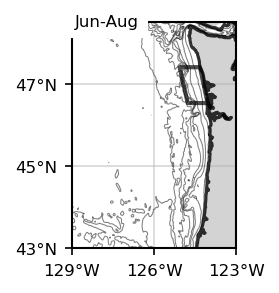

Dec-Feb
67
aqui


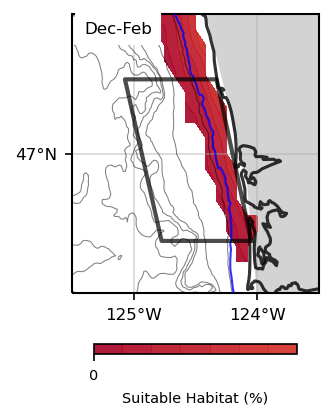

Jun-Aug
0
no hay datos: 0


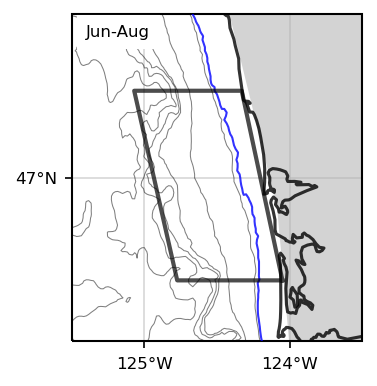

Chinook
bottom
Dec-Feb
464
aqui


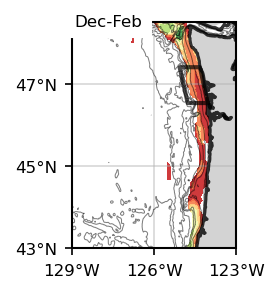

Jun-Aug
210
aqui


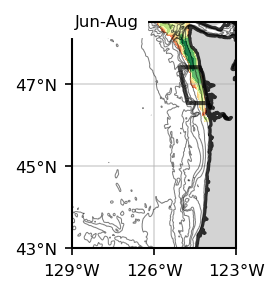

Dec-Feb
127
aqui


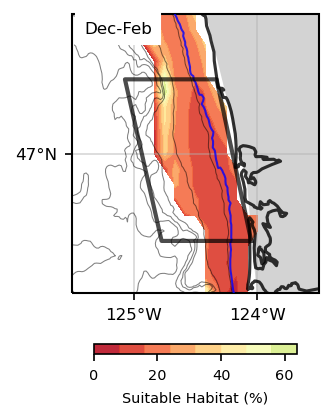

Jun-Aug
89
aqui


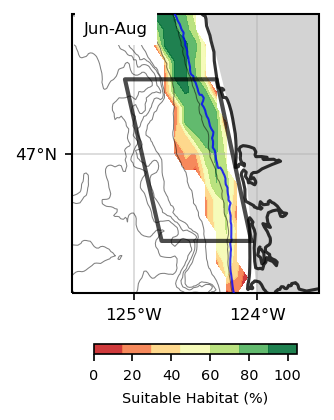

Coho
surface
Dec-Feb
2366
aqui


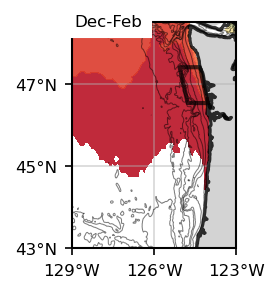

Jun-Aug
0
no hay datos: 0


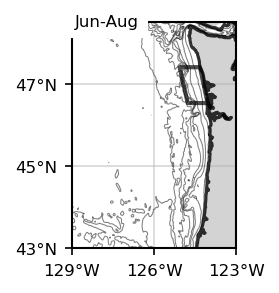

Dec-Feb
308
aqui


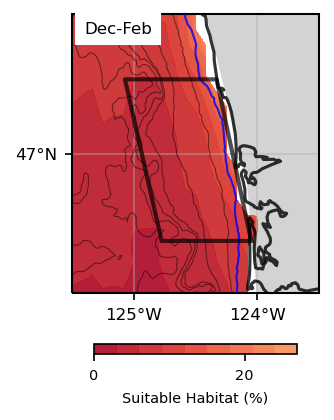

Jun-Aug
0
no hay datos: 0


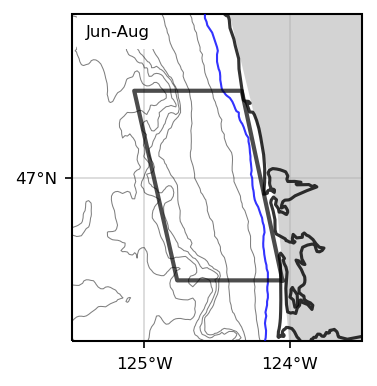

Coho
bottom
Dec-Feb
444
aqui


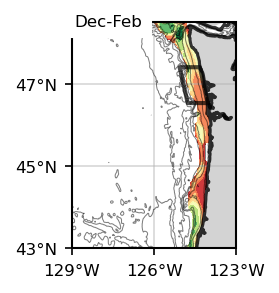

Jun-Aug
201
aqui


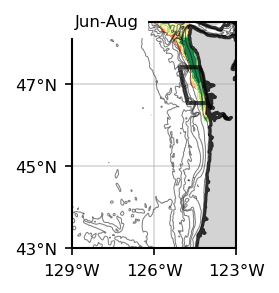

Dec-Feb
128
aqui


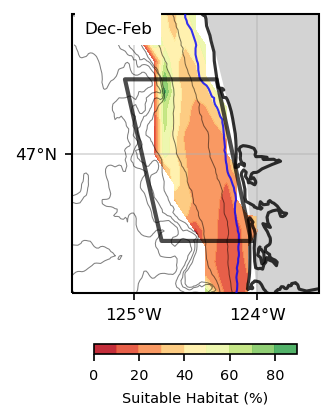

Jun-Aug
94
aqui


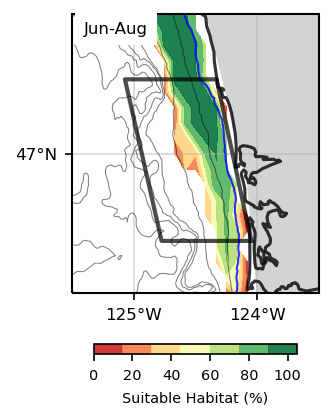

Razor Clams
surface
Dec-Feb
3474
aqui


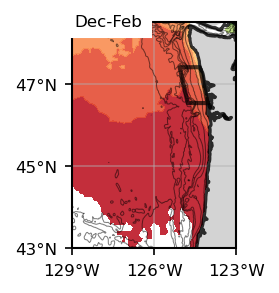

Jun-Aug
1
no hay datos: 1


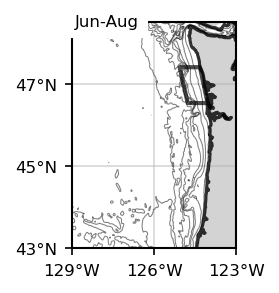

Dec-Feb
308
aqui


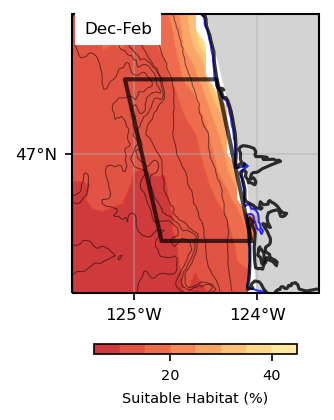

Jun-Aug
0
no hay datos: 0


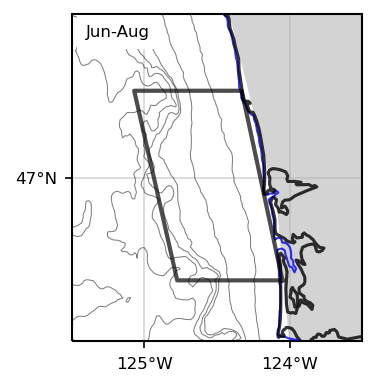

Razor Clams
bottom
Dec-Feb
210
aqui


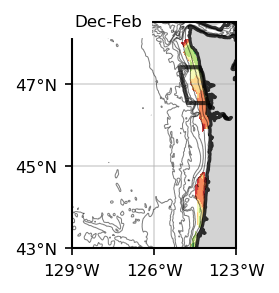

Jun-Aug
37
aqui


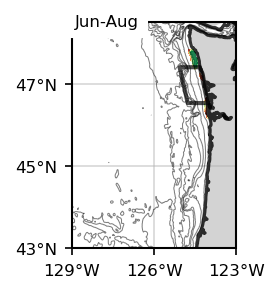

Dec-Feb
97
aqui


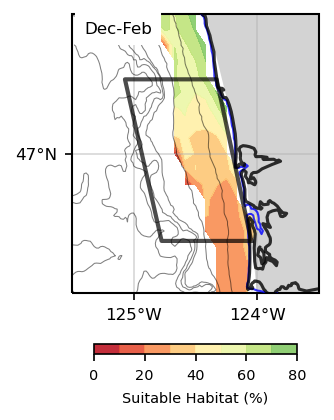

Jun-Aug
32
aqui


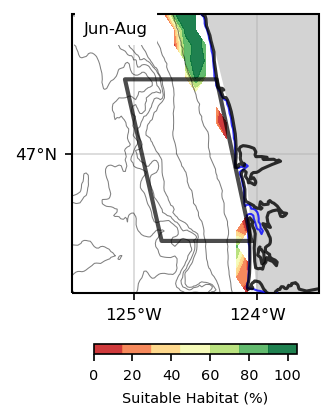

Albacore
surface
Dec-Feb
3890
aqui


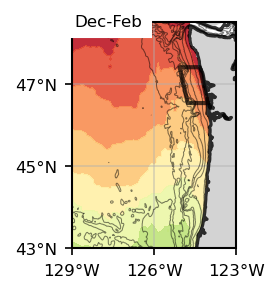

Jun-Aug
3914
aqui


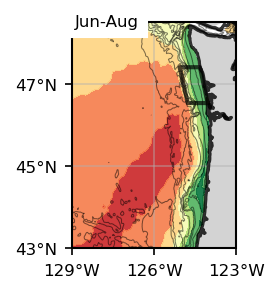

Dec-Feb
308
aqui


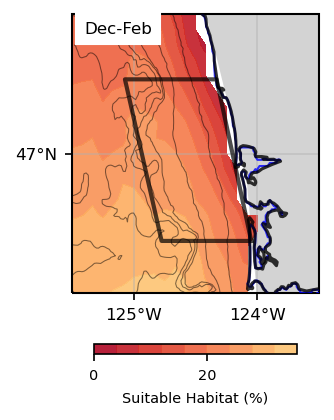

Jun-Aug
308
aqui


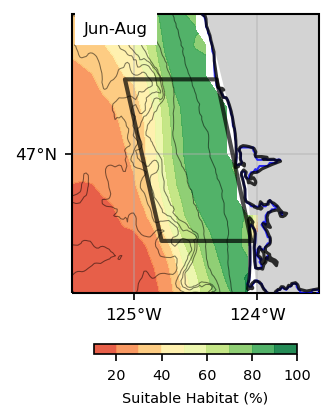

Albacore
bottom
Dec-Feb
77
aqui


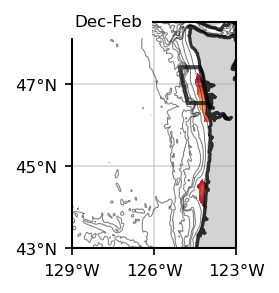

Jun-Aug
6
no hay datos: 6


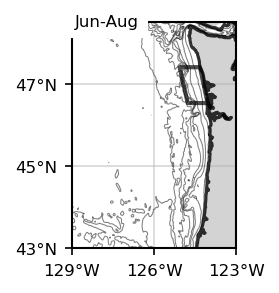

Dec-Feb
44
aqui


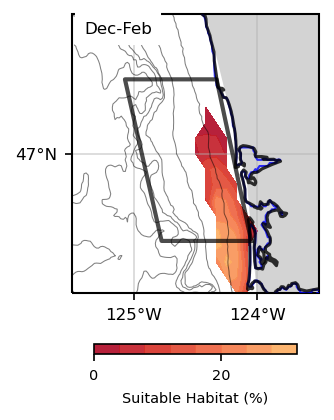

Jun-Aug
6
no hay datos: 6


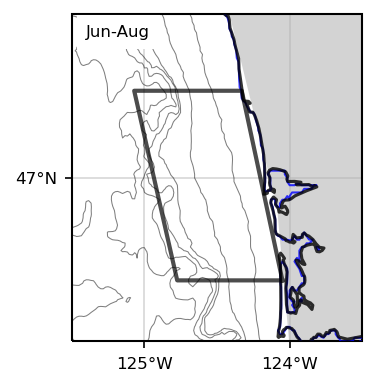

In [16]:
tit='Suitable Habitat (%)'
for ssp in ssps:
    for fishn in range(len(fishes)-1):
        for dp in depth:
            print(fishes[fishn])
            print(dp)
            fn = ldp+'QIN/downscaled_data/suitable_habitat_v2/future_season_OT_'+fishes[fishn]+'_'+ssp+'_'+dp+'_allmods.nc'
            ds_present = xr.open_dataset(fn)
            ds_present.close()
            ds_present = ds_present.where(ds_present.season!='MAM',drop=True)
            ds_present = ds_present.where(ds_present.season!='SON',drop=True)

            # average across models (variables in the data frame)
            meanx = ds_present.to_array(dim='new').mean('new', skipna=True)
            ds_present['allmod']=meanx.where(meanx>=1)

            make_map(ds_present.allmod, lnep,  tit, dp, ssp, cbs=False)

            ds_present = ds_present.sel(lat=slice(lqin[0,0],lqin[0,1]),lon=slice(lqin[1,0],lqin[1,1]))

            make_map(ds_present.allmod, lqin, tit, dp, ssp, depth=True, d1=fishdt.at[fishn,'Dm'])
            
